------
**You cannot save any changes you make to this file, so please make sure to save it on your Google Colab drive or download it as a .ipynb file.**

------

 

Practical 1: Sentiment Detection in Movie Reviews
========================================



This practical concerns detecting sentiment in movie reviews. This is a typical NLP classification task.
In [this file](https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json) (80MB) you will find 1000 positive and 1000 negative **movie reviews**.
Each review is a **document** and consists of one or more sentences.

To prepare yourself for this practical, you should
have a look at a few of these texts to understand the difficulties of
the task: how might one go about classifying the texts? You will write
code that decides whether a movie review conveys positive or
negative sentiment.

Please make sure you have read the following paper:

>   Bo Pang, Lillian Lee, and Shivakumar Vaithyanathan
(2002). 
[Thumbs up? Sentiment Classification using Machine Learning
Techniques](https://dl.acm.org/citation.cfm?id=1118704). EMNLP.

Bo Pang et al. introduced the movie review sentiment
classification task, and the above paper was one of the first papers on
the topic. The first version of your sentiment classifier will do
something similar to Pang et al.'s system. If you have questions about it,
you should resolve you doubts as soon as possible with your TA.


**Advice**

Please read through the entire practical and familiarise
yourself with all requirements before you start coding or otherwise
solving the tasks. Writing clean and concise code can make the difference
between solving the assignment in a matter of hours, and taking days to
run all experiments.

## Environment

All code should be written in **Python 3**. 
This is the default in Google Colab.

In [1]:
!python --version

Python 3.6.13 :: Anaconda, Inc.


If you want to run code on your own computer, then download this notebook through `File -> Download .ipynb`.
The easiest way to
install Python is through downloading
[Anaconda](https://www.anaconda.com/download). 
After installation, you can start the notebook by typing `jupyter notebook filename.ipynb`.
You can also use an IDE
such as [PyCharm](https://www.jetbrains.com/pycharm/download/) to make
coding and debugging easier. It is good practice to create a [virtual
environment](https://docs.python.org/3/tutorial/venv.html) for this
project, so that any Python packages don’t interfere with other
projects. 
 

**Learning Python 3**

If you are new to Python 3, you may want to check out a few of these resources:
- https://learnxinyminutes.com/docs/python3/
- https://www.learnpython.org/
- https://docs.python.org/3/tutorial/

In [2]:
import math
import os
import sys
from subprocess import call
from nltk import FreqDist
from nltk.util import ngrams
from nltk.stem.porter import PorterStemmer
import sklearn as sk
from google.colab import drive
import pickle
import json
from collections import Counter
import requests
import matplotlib.pyplot as plt
import numpy as np

## Loading the data

**Download the sentiment lexicon and the movie reviews dataset.**

In [ ]:
# download sentiment lexicon
!wget https://gist.githubusercontent.com/bastings/d6f99dcb6c82231b94b013031356ba05/raw/f80a0281eba8621b122012c89c8b5e2200b39fd6/sent_lexicon --no-check-certificate
# download review data
!wget https://gist.githubusercontent.com/bastings/d47423301cca214e3930061a5a75e177/raw/5113687382919e22b1f09ce71a8fecd1687a5760/reviews.json --no-check-certificate

**Load the movie reviews.**

Each word in a review comes with its part-of-speech tag. For documentation on POS-tags, see https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf.


In [3]:
# file structure:
# [
#  {"cv": integer, "sentiment": str, "content": list} 
#  {"cv": integer, "sentiment": str, "content": list} 
#   ..
# ]
# where `content` is a list of sentences, 
# with a sentence being a list of (token, pos_tag) pairs.


with open("reviews.json", mode="r", encoding="utf-8") as f:
  reviews = json.load(f)
  
print("Total number of reviews:", len(reviews), '\n')

def print_sentence_with_pos(s):
  print(" ".join("%s/%s" % (token, pos_tag) for token, pos_tag in s))

for i, r in enumerate(reviews):
  print(r["cv"], r["sentiment"], len(r["content"]))  # cv, sentiment, num sents
  print_sentence_with_pos(r["content"][0])
  if i == 4: 
    break
    
c = Counter()
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      c[token.lower()] += 1
      
print("\nNumber of word types:", len(c))
print("Number of word tokens:", sum(c.values()))

print("\nMost common tokens:")
for token, count in c.most_common(20):
  print("%10s : %8d" % (token, count))
  

Total number of reviews: 2000 

0 NEG 29
Two/CD teen/JJ couples/NNS go/VBP to/TO a/DT church/NN party/NN ,/, drink/NN and/CC then/RB drive/NN ./.
1 NEG 11
Damn/JJ that/IN Y2K/CD bug/NN ./.
2 NEG 24
It/PRP is/VBZ movies/NNS like/IN these/DT that/WDT make/VBP a/DT jaded/JJ movie/NN viewer/NN thankful/JJ for/IN the/DT invention/NN of/IN the/DT Timex/NNP IndiGlo/NNP watch/NN ./.
3 NEG 19
QUEST/NN FOR/IN CAMELOT/NNP ``/`` Quest/NNP for/IN Camelot/NNP ''/'' is/VBZ Warner/NNP Bros./NNP '/POS first/JJ feature-length/JJ ,/, fully-animated/JJ attempt/NN to/TO steal/VB clout/NN from/IN Disney/NNP 's/POS cartoon/NN empire/NN ,/, but/CC the/DT mouse/NN has/VBZ no/DT reason/NN to/TO be/VB worried/VBN ./.
4 NEG 38
Synopsis/NNPS :/: A/DT mentally/RB unstable/JJ man/NN undergoing/VBG psychotherapy/NN saves/VBZ a/DT boy/NN from/IN a/DT potentially/RB fatal/JJ accident/NN and/CC then/RB falls/VBZ in/IN love/NN with/IN the/DT boy/NN 's/POS mother/NN ,/, a/DT fledgling/NN restauranteur/NN ./.

Number of wo

# Lexicon-based approach (3.5pts)



A traditional approach to classify documents according to their sentiment is the lexicon-based approach. To implement this approach, you need a **sentiment lexicon**, i.e., a list of words annotated with a sentiment label (e.g., positive and negative, or a score from 0 to 5).

In this practical, you will use the sentiment
lexicon released by Wilson et al. (2005).

> Theresa Wilson, Janyce Wiebe, and Paul Hoffmann
(2005). [Recognizing Contextual Polarity in Phrase-Level Sentiment
Analysis](http://www.aclweb.org/anthology/H/H05/H05-1044.pdf). HLT-EMNLP.

Pay attention to all the information available in the sentiment lexicon. The field *word1* contains the lemma, *priorpolarity* contains the sentiment label (positive, negative, both, or neutral), *type* gives you the magnitude of the word's sentiment (strong or weak), and *pos1* gives you the part-of-speech tag of the lemma. Some lemmas can have multiple part-of-speech tags and thus multiple entries in the lexicon. The path of the lexicon file is `"sent_lexicon"`.


In [4]:
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  line_cnt = 0
  for line in f:
    print(line.strip())
    line_cnt += 1
    if line_cnt > 4:
      break

type=weaksubj len=1 word1=abandoned pos1=adj stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandonment pos1=noun stemmed1=n priorpolarity=negative
type=weaksubj len=1 word1=abandon pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abase pos1=verb stemmed1=y priorpolarity=negative
type=strongsubj len=1 word1=abasement pos1=anypos stemmed1=y priorpolarity=negative


Lexica such as this can be used to solve
the classification task without using Machine Learning. For example, one might look up every word $w_1 ... w_n$ in a document, and compute a **binary score**
$S_{binary}$ by counting how many words have a positive or a
negative label in the sentiment lexicon $SLex$.

$$S_{binary}(w_1 w_2 ... w_n) = \sum_{i = 1}^{n}\text{sign}(SLex\big[w_i\big])$$

where $\text{sign}(SLex\big[w_i\big])$ refers to the polarity of $w_i$.

**Threshold.** On average, there are more positive than negative words per review (~7.13 more positive than negative per review) to take this bias into account you should use a threshold of **8** (roughly the bias itself) to make it harder to classify as positive.

$$
\text{classify}(S_{binary}(w_1 w_2 ... w_n)) = \bigg\{\begin{array}{ll}
        \text{positive} & \text{if } S_{binary}(w_1w_2...w_n) > threshold\\
        \text{negative} & \text{otherwise}
        \end{array}
$$


#### (Q1.1) Implement this approach and report its classification accuracy. (1 pt)

In [5]:
# YOUR CODE HERE

# first create a nice dictionary of the sentiment lexicon
sent_dict = {}
with open("sent_lexicon", mode="r", encoding="utf-8") as f:
  for line in f:
    splitted_line = line.split()
    word = splitted_line[2].split('=')[1]
    magnitude = splitted_line[0].split('=')[1]
    polarity = splitted_line[5].split('=')[1]
    sent_dict[word] = (polarity, magnitude)

In [6]:
def Sbin_review(review, strong_multiplier=1, weak_multiplier=1, threshold=8):
  """
  If not using the magnitude, set strong_multiplier and weak_multiplier to 1 (default)
  """
  scores = []
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      if token.lower() in sent_dict:
        pol, magnitude = sent_dict[token.lower()]
        if pol == 'positive':
          if magnitude == 'strongsubj':
            score = strong_multiplier * 1
          elif magnitude == 'weaksubj':
            score = weak_multiplier * 1
        elif pol == 'negative':
          if magnitude == 'strongsubj':
            score = strong_multiplier * -1
          elif magnitude == 'weaksubj':
            score = weak_multiplier * -1
        else: 
          score = 0
        scores.append(score)

  if sum(scores) > threshold:
    pred_label = 'POS'
  else:
    pred_label = 'NEG'

  return pred_label
          


In [7]:
token_results = []
for review in reviews:
  target_label = review['sentiment']
  pred_label = Sbin_review(review)
  if pred_label == target_label:
    token_results.append(1)
  else:
    token_results.append(0)

# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_accuracy = sum(token_results)/len(token_results)
print("Accuracy: %0.2f" % token_accuracy)

Accuracy: 0.68


As the sentiment lexicon also has information about the **magnitude** of
sentiment (e.g., *“excellent"* has the same sentiment _polarity_ as *“good"* but it has a higher magnitude), we can take a more fine-grained approach by adding up all
sentiment scores, and deciding the polarity of the movie review using
the sign of the weighted score $S_{weighted}$.

$$S_{weighted}(w_1w_2...w_n) = \sum_{i = 1}^{n}SLex\big[w_i\big]$$


Make sure you define an appropriate threshold for this approach.

#### (Q1.2) Now incorporate magnitude information and report the classification accuracy. Don't forget to use the threshold. (1pt)

In [8]:
# YOUR CODE HERE
# the main implementation for this question in done in the previous
# function Sbin_review, using multipliers
magnitude_results = []
for review in reviews:
  target_label = review['sentiment']
  pred_label = Sbin_review(review, strong_multiplier=2, weak_multiplier=0.5)
  if pred_label == target_label:
    magnitude_results.append(1)
  else:
    magnitude_results.append(0)

magnitude_accuracy = sum(magnitude_results)/len(magnitude_results) 
print("Accuracy: %0.3f" % magnitude_accuracy)

Accuracy: 0.694


#### (Q.1.4) Make a barplot of the two results (0.5pt)

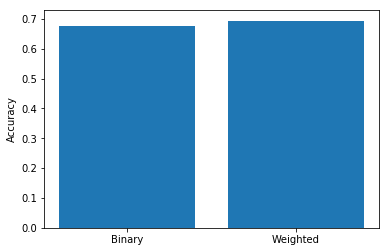

In [9]:
# YOUR CODE HERE
plt.bar([0, 1], [token_accuracy, magnitude_accuracy])
plt.xticks([0, 1], ["Binary", "Weighted"])
plt.ylabel("Accuracy")
plt.show()

#### (Q1.3) A better threshold (1pt)
Above we have defined a threshold to account for an inherent bias in the dataset: there are more positive than negative words per review.
However, that threshold does not take into account *document length*. Explain why this is a problem and implement an alternative way to compute the threshold.

*Write your answer here.*

##### Answer
This threshold is constant, so it is independent from the length of the document/review. It is not based on the relative difference between negative and positive words, but on the absolute difference in negative and positive words. This leads to the problem that documents with a lot of words will always pass this constant threshold although their label is negative, assuming that positive words occur more than negative words relatively.

We can solve this problem by calculating a threshold that is relative to the length of each document (or review). We do this by calculating the relative threshold per token, which is multiplied by the length of the review/document to get the document-specific threshold.

In [10]:
# YOUR CODE HERE
lengths = []
for review in reviews:
  doc_length = 0
  for sentence in review["content"]:
    doc_length += len(sentence)
  lengths.append(doc_length)

avg_doc_length = sum(lengths)/len(lengths)

# so for each token:
positives_per_token = 7.13 / avg_doc_length

# then multiply positives_per_token with the doc_length and you get the
# classification threshold for each review 
print(positives_per_token)

0.009428978172510628


In [11]:
def flatten(l):
   return [item for sublist in l for item in sublist]

# get accuracy with better threshold that takes into account document length
token_results = []
for review in reviews:
  target_label = review['sentiment']
  thres = len(flatten(review['content']))*positives_per_token
  pred_label = Sbin_review(review, strong_multiplier=2, weak_multiplier=0.5, threshold=thres)
  if pred_label == target_label:
    token_results.append(1)
  else:
    token_results.append(0)

# token_results should be a list of binary indicators; for example [1, 0, 1, ...] 
# where 1 indicates a correct classification and 0 an incorrect classification.
token_accuracy = sum(token_results)/len(token_results)
print("Accuracy: %0.3f" % token_accuracy)

Accuracy: 0.692


# Naive Bayes (9.5pts)


Your second task is to program a simple Machine Learning approach that operates
on a simple Bag-of-Words (BoW) representation of the text data, as
described by Pang et al. (2002). In this approach, the only features we
will consider are the words in the text themselves, without bringing in
external sources of information. The BoW model is a popular way of
representing texts as vectors, making it
easy to apply classical Machine Learning algorithms on NLP tasks.
However, the BoW representation is also very crude, since it discards
all information related to word order and grammatical structure in the
original text—as the name suggests.

## Writing your own classifier (4pts)

Write your own code to implement the Naive Bayes (NB) classifier. As
a reminder, the Naive Bayes classifier works according to the following
equation:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} P(c|\bar{f}) = \operatorname*{arg\,max}_{c \in C} P(c)\prod^n_{i=1} P(f_i|c)$$
where $C = \{ \text{POS}, \text{NEG} \}$ is the set of possible classes,
$\hat{c} \in C$ is the most probable class, and $\bar{f}$ is the feature
vector. Remember that we use the log of these probabilities when making
a prediction:
$$\hat{c} = \operatorname*{arg\,max}_{c \in C} \Big\{\log P(c) + \sum^n_{i=1} \log P(f_i|c)\Big\}$$

You can find more details about Naive Bayes in [Jurafsky &
Martin](https://web.stanford.edu/~jurafsky/slp3/). You can also look at
this helpful
[pseudo-code](https://nlp.stanford.edu/IR-book/html/htmledition/naive-bayes-text-classification-1.html).

*Note: this section and the next aim to put you in a position to replicate
    Pang et al.'s Naive Bayes results. However, your numerical results
    will differ from theirs, as they used different data.*

**You must write the Naive Bayes training and prediction code from
scratch.** You will not be given credit for using off-the-shelf Machine
Learning libraries.

The data contains the text of the reviews, where each document consists
of the sentences in the review, the sentiment of the review and an index
(cv) that you will later use for cross-validation. The
text has already been tokenised and POS-tagged for you. Your algorithm
should read in the text, **lowercase it**, store the words and their
frequencies in an appropriate data structure that allows for easy
computation of the probabilities used in the Naive Bayes algorithm, and
then make predictions for new instances.


#### (Q2.1) Unseen words (1pt)
The presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive Bayes classifier to equal $0$.
These can be words which are unseen in both positive and negative training reviews (case 1), but also words which are seen in reviews _of only one sentiment class_ in the training dataset (case 2). In both cases, **you should skip these words for both classes**.  What would be the problem instead with skipping words only for one class in case 2? 

*Write your answer here.*

##### Answer
In case 2 we are skipping words only for one class in the training dataset, this leads to a problem because it increases the llikelihood of the class for which the word was skipped.

#### (Q2.2) Train your classifier on (positive and negative) reviews with cv-value 000-899, and test it on the remaining (positive and negative) reviews cv900–cv999.  Report results using classification accuracy as your evaluation metric. Your  features are the word vocabulary. The value of a feature is the count of that feature (word) in the document. (2pts)


In [12]:
def get_n_grams(sentence, n):
  tokenized_sent = [token.lower() for token, pos_tag in sentence]

  # only get ngrams if sentence is longer or equal than n
  if len(tokenized_sent) >= n:
    if n == 2:
      n_grams_in_sent = list(ngrams(tokenized_sent, n=n)) + list (tokenized_sent)
    if n == 3:
      n_grams_in_sent = list(ngrams(tokenized_sent, n=n)) + list(ngrams(tokenized_sent, n=n-1)) + list (tokenized_sent)  
    return n_grams_in_sent

  else:
    return None
  

def NB_train(training_reviews, sm_k=0, stemming=False, bi=False, tri=False):
  """
  Train the NB classifier by creating the frequency dictionary
  """

  if stemming == True:
    stemmer = PorterStemmer()
    # hold a dictionary for already stemmed words,
    # in order to avoid redundant stemming
    stem_mem = {}

  freqs = {'POS' : {}, 'NEG' : {}}
  
  pos_count = 0
  neg_count = 0

  for review in training_reviews:
    sentiment = review['sentiment']
    if sentiment == 'POS':
      pos_count += 1
    else:
      neg_count += 1

    for sentence in review['content']:
      for token, pos_tag in sentence:
        token = token.lower()
        if stemming == True:
          if token not in stem_mem:
            stemmed_token = stemmer.stem(token)
            stem_mem[token] = stemmed_token
            token = stemmed_token
          else:
            token = stem_mem[token]

        if token in freqs[sentiment]:
          freqs[sentiment][token] += 1
        else:
          freqs[sentiment][token] = 1

      if bi:
        bigrams = get_n_grams(sentence, 2)
        if bigrams != None:
          for bigram in bigrams:
            if bigram in freqs[sentiment]:
              freqs[sentiment][bigram] += 1
            else:
              freqs[sentiment][bigram] = 1
      if tri:
        trigrams = get_n_grams(sentence, 3)
        if trigrams != None:
          for trigram in trigrams:
            if trigram in freqs[sentiment]:
              freqs[sentiment][trigram] += 1
            else:
              freqs[sentiment][trigram] = 1


  if sm_k == 0:
    # skip the words that don't occur in both NEG and POS
    for word in list(freqs["NEG"]):
      if word not in freqs["POS"]:
        # remove word from dict
        del freqs["NEG"][word]
    for word in list(freqs["POS"]):
      if word not in freqs["NEG"]:
        # remove word from dict
        del freqs["POS"][word]

  elif sm_k > 0:
    # apply smoothing for words that don't occur in both NEG and POS
    for word in list(freqs["NEG"]):
      if word not in freqs["POS"]:
        # smooth on class where it didn't exist
        freqs["POS"][word] = sm_k
      else:
        # also add k to other class counts
        freqs["NEG"][word] += sm_k

    for word in list(freqs["POS"]):
      if word not in freqs["NEG"]:
        # smooth on class where it didn't exist
        freqs["NEG"][word] = sm_k
      # also add k to other class counts
      else:
        freqs["POS"][word] += sm_k


  # calculate priors
  Ppos = pos_count / (pos_count + neg_count)
  Pneg = neg_count / (pos_count + neg_count)

  return freqs, Ppos, Pneg

def NB_predict(review, freq_dict, Ppos, Pneg, sm_k=0, stemming=False, bi=False, tri=False):

  if stemming == True:
    stemmer = PorterStemmer()

  V_size = len(freq_dict['POS'])
  logp_pos = 0
  logp_neg = 0

  c_p = sum(freq_dict['POS'].values())
  c_n = sum(freq_dict['NEG'].values())

  for sentence in review["content"]:

    # unigram
    for token, pos_tag in sentence:
      token = token.lower()

      if stemming == True:
        token = stemmer.stem(token)
        
      if token in freq_dict['POS']:
        
        if sm_k > 0:
          logp_pos += np.log((freq_dict['POS'][token] + sm_k) / (c_p + V_size))
          logp_neg += np.log((freq_dict['NEG'][token] + sm_k) / (c_n + V_size))
        else:
          logp_pos += np.log(freq_dict['POS'][token] / c_p)
          logp_neg += np.log(freq_dict['NEG'][token] / c_n)

      elif sm_k > 0:
        logp_pos += np.log(sm_k / (c_p + V_size))
        logp_neg += np.log(sm_k / (c_n + V_size))

    
    # bigram
    if bi:
      logp_pos = 0
      logp_neg = 0  
      bigrams = get_n_grams(sentence, 2)
      if bigrams != None:
        for bigram in bigrams:
          if bigram in freq_dict['POS']:
            if sm_k > 0:
              logp_pos += np.log((freq_dict['POS'][bigram] + sm_k) / (c_p + V_size))
              logp_neg += np.log((freq_dict['NEG'][bigram] + sm_k) / (c_n + V_size))
            else:
              logp_pos += np.log(freq_dict['POS'][bigram] / c_p)
              logp_neg += np.log(freq_dict['NEG'][bigram] / c_n)

          elif sm_k > 0:
            logp_pos += np.log(sm_k / (c_p + V_size))
            logp_neg += np.log(sm_k / (c_n + V_size))

  
    # trigram
    if tri:
      logp_pos = 0
      logp_neg = 0
      trigrams = get_n_grams(sentence, 3)
      if trigrams != None:
        for trigram in trigrams:
          if trigram in freq_dict['POS']:
            if sm_k > 0:
              logp_pos += np.log((freq_dict['POS'][trigram] + sm_k) / (c_p + V_size))
              logp_neg += np.log((freq_dict['NEG'][trigram] + sm_k) / (c_n + V_size))
            else:
              logp_pos += np.log(freq_dict['POS'][trigram] / c_p)
              logp_neg += np.log(freq_dict['NEG'][trigram] / c_n)

          elif sm_k > 0:
            logp_pos += np.log(sm_k / (c_p + V_size))
            logp_neg += np.log(sm_k/ (c_n + V_size))
            
          
    
  # get posterior log probabilities and return class with highest log prob
  p = np.log(Ppos) + logp_pos
  n = np.log(Pneg) + logp_neg

  if n > p:
    return 'NEG'
  else:
    return 'POS'

In [13]:
# create datasets and train Naive Bayes
train_reviews = [review for review in reviews if review['cv'] < 900]
test_reviews = [review for review in reviews if review['cv'] > 899]
freq_dict, Ppos, Pneg = NB_train(train_reviews)

# get accuracy on test set
accs = []
for review in test_reviews:
  pred = NB_predict(review, freq_dict, Ppos, Pneg)
  if review['sentiment'] == pred:
    accs.append(1)
  else:
    accs.append(0)
print('Accuracy on the test set: {}%'.format(sum(accs)/ len(accs)))

Accuracy on the test set: 0.835%


#### (Q2.3) Would you consider accuracy to also be a good way to evaluate your classifier in a situation where 90% of your data instances are of positive movie reviews? (1pt)

Simulate this scenario by keeping the positive reviews
data unchanged, but only using negative reviews cv000–cv089 for
training, and cv900–cv909 for testing. Calculate the classification
accuracy, and explain what changed.

*Write your answer here.*

#### Answer
The accuracy is now 89.1%, which is better. However, if we let the classifier let all test samples classify as positive, the accuracy will be 90%, since the data is unbalanced with 90% positive samples. So accuracy is not a good measure in the case of an unbalanced dataset. Instead, we could use recall.

In [14]:
# YOUR CODE HERE
train_reviews = [review for review in reviews if (review['cv'] < 900 and  review['sentiment'] == 'POS') 
                or (review['cv'] < 89 and review['sentiment'] == 'NEG')]
test_reviews = [review for review in reviews if (review['cv'] > 899 and  review['sentiment'] == 'POS') 
                or (review['cv'] > 899 and review['cv'] < 910 and review['sentiment'] == 'NEG')]

freq_dict, Ppos, Pneg = NB_train(train_reviews)
accs = []
for review in test_reviews:
  pred = NB_predict(review, freq_dict, Ppos, Pneg)
  if review['sentiment'] == pred:
    accs.append(1)
  else:
    accs.append(0)
print('Accuracy on the test set: {}%'.format(round(sum(accs)/ len(accs), 3)))

Accuracy on the test set: 0.891%


## Smoothing (1pt)

As mentioned above, the presence of words in the test dataset that
have not been seen during training can cause probabilities in the Naive
Bayes classifier to be $0$, thus making that particular test instance
undecidable. The standard way to mitigate this effect (as well as to
give more clout to rare words) is to use smoothing, in which the
probability fraction
$$\frac{\text{count}(w_i, c)}{\sum\limits_{w\in V} \text{count}(w, c)}$$ for a word
$w_i$ becomes
$$\frac{\text{count}(w_i, c) + \text{smoothing}(w_i)}{\sum\limits_{w\in V} \text{count}(w, c) + \sum\limits_{w \in V} \text{smoothing}(w)}$$





#### (Q2.4) Implement Laplace feature smoothing (1pt)
Implement Laplace smoothing, i.e., smoothing with a constant value ($smoothing(w) = \kappa, \forall w \in V$), in your Naive
Bayes classifier’s code, and report the impact on performance. 
Use $\kappa = 1$.

In [15]:
# YOUR CODE HERE
train_reviews = [review for review in reviews if review['cv'] < 900]
test_reviews = [review for review in reviews if review['cv'] > 899]

freq_dict, Ppos, Pneg = NB_train(train_reviews, sm_k=1)
accs = []
for review in test_reviews:
  pred = NB_predict(review, freq_dict, Ppos, Pneg, sm_k=1)
  if review['sentiment'] == pred:
    accs.append(1)
  else:
    accs.append(0)
print('Accuracy on the test set: {}%'.format(sum(accs)/ len(accs)))

Accuracy on the test set: 0.825%


## Cross-Validation (1.5pts)

A serious danger in using Machine Learning on small datasets, with many
iterations of slightly different versions of the algorithms, is ending up with Type III errors, also called the “testing hypotheses
suggested by the data” errors. This type of error occurs when we make
repeated improvements to our classifiers by playing with features and
their processing, but we don’t get a fresh, never-before seen test
dataset every time. Thus, we risk developing a classifier that gets better
and better on our data, but only gets worse at generalizing to new, unseen data. In other words, we risk developping a classifier that overfits.

A simple method to guard against Type III errors is to use
Cross-Validation. In **N-fold Cross-Validation**, we divide the data into N
distinct chunks, or folds. Then, we repeat the experiment N times: each
time holding out one of the folds for testing, training our classifier
on the remaining N - 1 data folds, and reporting performance on the
held-out fold. We can use different strategies for dividing the data:

-   Consecutive splitting:
  - cv000–cv099 = Split 1
  - cv100–cv199 = Split 2
  - etc.
  
-   Round-robin splitting (mod 10):
  - cv000, cv010, cv020, … = Split 1
  - cv001, cv011, cv021, … = Split 2
  - etc.

-   Random sampling/splitting
  - Not used here (but you may choose to split this way in a non-educational situation)



#### (Q2.5) Write the code to implement 10-fold cross-validation using round-robin splitting for your Naive Bayes classifier from Q2.4 and compute the 10 accuracies. Report the final performance, which is the average of the performances per fold. If all splits perform equally well, this is a good sign. (1pt)

In [16]:
# YOUR CODE HERE
from collections import defaultdict

def create_ten_folds(reviews):
  # create folds
  ten_folds = defaultdict(list)
  for review in reviews:
    split_idx = review['cv'] % 10
    ten_folds[split_idx].append(review)
  return ten_folds

# apply cross validation with given parameters 
def cross_validation(folds, smoothing_k=0, stem=False, bigram=False, trigram=False):
  test_split_idx = len(folds) - 1
  accs = []

  it_n = 0
  while True:
    
    if test_split_idx < 0:
      break

    it_n += 1
    print('Iteration {}/10'.format(it_n))

    training_set = []
    for split in folds:
      if split != test_split_idx:
        training_set += folds[split]
    
    # train on training folds
    freq_dict, Ppos, Pneg = NB_train(training_set, sm_k=smoothing_k, stemming=stem, bi=bigram, tri=trigram)

    # test on test fold and print accuracy
    test_set = folds[test_split_idx]
    results = []
    for review in test_set:
      pred = NB_predict(review, freq_dict, Ppos, Pneg, sm_k=smoothing_k, stemming=stem, bi=bigram, tri=trigram)
      if review['sentiment'] == pred:
        results.append(1)
      else:
        results.append(0)

    accuracy = sum(results)/len(results)

    accs.append(accuracy)
    test_split_idx += -1

  accs = np.array(accs)

  return accs, np.round(np.mean(accs), 3)

In [17]:
ten_folds = create_ten_folds(reviews)
accs, mean_acc = cross_validation(ten_folds, smoothing_k=1)
print('Average accuracy:', mean_acc)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Average accuracy: 0.815


#### (Q2.6) Report the variance of the 10 accuracy scores. (0.5pt)

**Please report all future results using 10-fold cross-validation now
(unless told to use the held-out test set).**

In [18]:
# YOUR CODE HERE
print('The variance of the 10 accuracy scores is {}'.format(np.var(accs)))

The variance of the 10 accuracy scores is 0.0005772499999999987


## Features, overfitting, and the curse of dimensionality

In the Bag-of-Words model, ideally we would like each distinct word in
the text to be mapped to its own dimension in the output vector
representation. However, real world text is messy, and we need to decide
on what we consider to be a word. For example, is “`word`" different
from “`Word`", from “`word`”, or from “`words`"? Too strict a
definition, and the number of features explodes, while our algorithm
fails to learn anything generalisable. Too lax, and we risk destroying
our learning signal. In the following section, you will learn about
confronting the feature sparsity and the overfitting problems as they
occur in NLP classification tasks.

### Stemming (1.5pts)

To make your algorithm more robust, use stemming and hash different inflections of a word to the same feature in the BoW vector space. Please use the [Porter stemming
    algorithm](http://www.nltk.org/howto/stem.html) from NLTK.



In [19]:
# YOUR CODE HERE
ten_folds = create_ten_folds(reviews)
accs, mean_acc = cross_validation(ten_folds, smoothing_k=1, stem=True)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10


#### (Q2.7): How does the performance of your classifier change when you use stemming on your training and test datasets? (1pt)
Use cross-validation to evaluate the classifier. 


In [20]:
# YOUR ANSWER HERE
print('Average accuracy when using stemming:', mean_acc)
print('The variance of the 10 accuracy scores is {}'.format(np.var(accs)))

Average accuracy when using stemming: 0.809
The variance of the 10 accuracy scores is 0.0009639999999999985


#### (Q2.8) What happens to the number of features (i.e., the size of the vocabulary) when using stemming as opposed to (Q2.4)? (0.5pt)
Give actual numbers. You can use the held-out training set to determine these.

In [21]:
# YOUR CODE HERE
train_reviews = [review for review in reviews if review['cv'] < 900]
freq_dict_nostem, _, _ = NB_train(train_reviews, sm_k=1, stemming=False)
freq_dict_stem, _, _ = NB_train(train_reviews, sm_k=1, stemming=True)

print('Size of vocabulary without stemming: {}'.format(len(freq_dict_nostem['POS'])))
print('Size of vocabulary with stemming: {}'.format(len(freq_dict_stem['POS'])))
print('So as you can see, the number of features/the size of the vocabulary decreases.')

Size of vocabulary without stemming: 45348
Size of vocabulary with stemming: 32404
So as you can see, the number of features/the size of the vocabulary decreases.


### N-grams (1.5pts)

A simple way of retaining some of the word
order information when using bag-of-words representations is to use **n-gram** features. 






#### (Q2.9) Retrain your classifier from (Q2.4) using **unigrams+bigrams** and **unigrams+bigrams+trigrams** as features. (1pt)
Report accuracy and compare it with that of the approaches you have previously implemented. You are allowed to use NLTK to build n-grams from sentences.

In [22]:
# YOUR CODE HERE
accs, mean_acc = cross_validation(ten_folds, smoothing_k=1, stem=False, bigram=True)
print('Average accuracy with unigrams + bigrams:', mean_acc)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Average accuracy with unigrams + bigrams: 0.68


In [23]:
accs, mean_acc = cross_validation(ten_folds, smoothing_k=1, stem=False, bigram=True, trigram=True)
print('Average accuracy with unigrams + bigrams + trigrams:', mean_acc)

Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
Average accuracy with unigrams + bigrams + trigrams: 0.66



#### Q2.10: How many features does the BoW model have to take into account now? (0.5pt)
How would you expect the number of features to increase theoretically (e.g., linear, square, cubed, exponential)? How does this number compare, in practice, to the number of features at (Q2.8)?

Use the held-out training set once again for this.


*Write your answer here.*

In [24]:
# YOUR CODE HERE
train_reviews = [review for review in reviews if review['cv'] < 900]
freq_dict_uni, _, _ = NB_train(train_reviews, sm_k=1)
freq_dict_uni_bi, _, _ = NB_train(train_reviews, sm_k=1, bi=True)
freq_dict_uni_bi_tri, _, _ = NB_train(train_reviews, sm_k=1, bi=True, tri=True)

print('Size of vocabulary with unigrams only: {}'.format(len(freq_dict_uni['POS'])))
print('Size of vocabulary with unigrams + bigrams: {}'.format(len(freq_dict_uni_bi['POS'])))
print('Size of vocabulary with unigrams + bigrams + trigrams: {}'.format(len(freq_dict_uni_bi_tri['POS'])))

Size of vocabulary with unigrams only: 45348
Size of vocabulary with unigrams + bigrams: 465262
Size of vocabulary with unigrams + bigrams + trigrams: 1346107


#### Answer
In theory, it can increase quadratic with bigrams and cubed for trigrams, but this is only in the worst case where bigrams and trigrams occcur that are grammatically or semantically incorrect (e.g. 'The' followed by 'the' etc.). So in practice, this theory will be unlikely. Above you can see what we observed in practice: from unigrams to uni+bigrams we go from 45348 to 465262 features and from that we go to 1346107 features. This is not quadratic or cubed increase, but rather a (highly) linear increase.

# Support Vector Machines (4pts)

Though simple to understand, implement, and debug, one
major problem with the Naive Bayes classifier is that its performance
deteriorates (becomes skewed) when it is being used with features which
are not independent (i.e., are correlated). Another popular classifier
that doesn’t scale as well to big data, and is not as simple to debug as
Naive Bayes, but that doesn’t assume feature independence is the Support
Vector Machine (SVM) classifier.

You can find more details about SVMs in Chapter 7 of Bishop: Pattern Recognition and Machine Learning.
Other sources for learning SVM:
* http://web.mit.edu/zoya/www/SVM.pdf
* http://www.cs.columbia.edu/~kathy/cs4701/documents/jason_svm_tutorial.pdf
* https://pythonprogramming.net/support-vector-machine-intro-machine-learning-tutorial/







Use the scikit-learn implementation of 
[SVM](http://scikit-learn.org/stable/modules/svm.html) with the default parameters. (You are not expected to perform any hyperparameter tuning, but feel free to do it if you think it gives you good insights for the discussion in question 5.)



#### (Q3.1): Train SVM and compare to Naive Bayes (2pts)

Train an SVM classifier (sklearn.svm.LinearSVC) using the features collected for Naive Bayes. Compare the
classification performance of the SVM classifier to that of the Naive
Bayes classifier with smoothing.
Use cross-validation to evaluate the performance of the classifiers.



In [25]:
# YOUR CODE HERE
def flatten(l):
   return [item for sublist in l for item in sublist]

In [26]:
from copy import deepcopy

# create empty vocabulary for encoding 
empty_vocab = defaultdict(int)
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
      empty_vocab[token.lower()] = 0

def encode_review(review):
  dictio = deepcopy(empty_vocab)
  for word in review:
    # use one hot encoding (so based on word presence)
    dictio[word] += 1
    
  return np.array(list(dictio.values()))

# now encode each review and create encoded reviews dataset
# NOTE: can take a while
reviews_dataset = []
progress = 0
for review in reviews:
  print('\rEncoding progress: {}/{}'.format(progress+1, len(reviews)), end='')
  progress += 1
  rev = {}
  rev['cv'] = review['cv']
  rev['sentiment'] = review['sentiment']
  rev['content'] = []
  for sentence in review["content"]:
    sent = []
    for token, pos_tag in sentence:
      sent.append(token.lower())
    rev['content'].append(sent)
  rev['content'] = encode_review(flatten(rev['content']))
  reviews_dataset.append(rev)
  

Encoding progress: 2000/2000

In [27]:
from sklearn.svm import LinearSVC
# create folds
ten_fold_set_X = defaultdict(list)
ten_fold_set_y = defaultdict(list)
for review in reviews_dataset:
  split_idx = review['cv'] % 10
  ten_fold_set_X[split_idx].append(review['content'])
  ten_fold_set_y[split_idx].append(review['sentiment'])

# apply 10-fold cross validation
test_split_idx = 10-1

accs = []
while True:
  if test_split_idx < 0:
    break
  training_X = []
  training_y = []
  for split in ten_fold_set_X:
    if split != test_split_idx:
      training_X += ten_fold_set_X[split]
      training_y += ten_fold_set_y[split]
  

  # test on test fold and print accuracy
  test_X = ten_fold_set_X[test_split_idx]
  test_y = ten_fold_set_y[test_split_idx]

  # train and test SVM
  lsvc = LinearSVC(max_iter=1200000)
  lsvc.fit(np.array(training_X), training_y)
  score = lsvc.score(np.array(test_X), test_y)
  accs.append(score)
  test_split_idx += -1
accs = np.array(accs)
print('SVM performance (accuracy): {}'.format(np.round(np.mean(accs), 3)))

# Compare with Naive Bayes
ten_folds = create_ten_folds(reviews)
accs, mean_acc = cross_validation(ten_folds, smoothing_k=1)
print('NB + smoothing performance (accuracy):', mean_acc)

SVM performance (accuracy): 0.832
Iteration 1/10
Iteration 2/10
Iteration 3/10
Iteration 4/10
Iteration 5/10
Iteration 6/10
Iteration 7/10
Iteration 8/10
Iteration 9/10
Iteration 10/10
NB + smoothing performance (accuracy): 0.815


### POS disambiguation (2pts)

Now add in part-of-speech features. You will find the
movie review dataset has already been POS-tagged for you ([here](https://catalog.ldc.upenn.edu/docs/LDC99T42/tagguid1.pdf) you find the tagset). Try to
replicate the results obtained by Pang et al. (2002).



####(Q3.2) Replace your features with word+POS features, and report performance with the SVM. Use cross-validation to evaluate the classifier and compare the results with (Q3.1). Does part-of-speech information help? Explain why this may be the case. (1pt)


In [28]:
# YOUR CODE HERE
# create empty vocabulary for encoding, including POS 
empty_vocab = defaultdict(int)
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
        key = token.lower() + '/' + pos_tag
        empty_vocab[key] = 0

def encode_review(review):
  dictio = deepcopy(empty_vocab)
  for word in review:
    dictio[word] += 1
  return np.array(list(dictio.values()))

# now encode each review and create encoded reviews dataset
reviews_dataset_pos = []
progress = 0
for review in reviews:
  print('\rEncoding progress: {}/{}'.format(progress+1, len(reviews)), end='')
  progress += 1
  rev = {}
  rev['cv'] = review['cv']
  rev['sentiment'] = review['sentiment']
  rev['content'] = []
  for sentence in review["content"]:
    sent = []
    for token, pos_tag in sentence:
      sent.append(token.lower() + '/' + pos_tag)
    rev['content'].append(sent)
  rev['content'] = encode_review(flatten(rev['content']))
  reviews_dataset_pos.append(rev)
  

Encoding progress: 2000/2000

In [29]:
# create folds
ten_fold_set_X = defaultdict(list)
ten_fold_set_y = defaultdict(list)
for review in reviews_dataset_pos:
  split_idx = review['cv'] % 10
  ten_fold_set_X[split_idx].append(review['content'])
  ten_fold_set_y[split_idx].append(review['sentiment'])

# apply 10-fold cross validation
test_split_idx = 10-1

accs = []
while True:
  if test_split_idx < 0:
    break
  training_X = []
  training_y = []
  for split in ten_fold_set_X:
    if split != test_split_idx:
      training_X += ten_fold_set_X[split]
      training_y += ten_fold_set_y[split]
  

  # test on test fold and print accuracy
  test_X = ten_fold_set_X[test_split_idx]
  test_y = ten_fold_set_y[test_split_idx]

  # train and test SVM
  lsvc = LinearSVC(max_iter=1200000)
  lsvc.fit(np.array(training_X), training_y)
  score = lsvc.score(np.array(test_X), test_y)
  accs.append(score)
  test_split_idx += -1
accs = np.array(accs)
print('SVM incl. POS tags performance (accuracy): {}'.format(np.round(np.mean(accs), 3)))

SVM incl. POS tags performance (accuracy): 0.838


*Write your answer here.*

##### Answer
As you can see, the accuracy for SVM increases when coorporating POS tags. However, the increase is small and does not seem significant. This result suggests that adding a POS tag does not encode additional information. 

#### (Q3.3) Discard all closed-class words from your data (keep only nouns, verbs, adjectives, and adverbs), and report performance. Does this help? Use cross-validation to evaluate the classifier and compare the results with (Q3.2). Are closed-class words detrimental to the classifier? Explain why this may be the case. (1pt)

In [30]:
# YOUR CODE HERE
open_class = ['JJ', 'JJR', 'JJS', 'NN', 'NNS', 'NNP', 'NNPS', 'VB', 'RB', 'RBR','RP', 'RBS', 'VBZ','VBP','MD' 'VBD', 'VBG', 'VBN', 'VBZ', 'VBP']

# create empty vocabulary for encoding, including POS 
empty_vocab = defaultdict(int)
for review in reviews:
  for sentence in review["content"]:
    for token, pos_tag in sentence:
        if pos_tag in open_class:
            key = token.lower() + '/' + pos_tag
            empty_vocab[key] = 0

def encode_review(review):
  dictio = deepcopy(empty_vocab)
  for word in review: 
    dictio[word] += 1
  return np.array(list(dictio.values()))

# now encode each review and create encoded reviews dataset
reviews_dataset_oc = []
progress = 0
for review in reviews:
  print('\rEncoding progress: {}/{}'.format(progress+1, len(reviews)), end='')
  progress += 1
  rev = {}
  rev['cv'] = review['cv']
  rev['sentiment'] = review['sentiment']
  rev['content'] = []
  for sentence in review["content"]:
    sent = []
    for token, pos_tag in sentence:
      if pos_tag in open_class:
        sent.append(token.lower() + '/' + pos_tag)
    rev['content'].append(sent)
  rev['content'] = encode_review(flatten(rev['content']))
  reviews_dataset_oc.append(rev)
  

Encoding progress: 2000/2000

In [31]:
# create folds
ten_fold_set_X = defaultdict(list)
ten_fold_set_y = defaultdict(list)
for review in reviews_dataset_oc:
  split_idx = review['cv'] % 10
  ten_fold_set_X[split_idx].append(review['content'])
  ten_fold_set_y[split_idx].append(review['sentiment'])

# apply 10-fold cross validation
test_split_idx = 10-1

accs = []
while True:
  if test_split_idx < 0:
    break
  training_X = []
  training_y = []
  for split in ten_fold_set_X:
    if split != test_split_idx:
      training_X += ten_fold_set_X[split]
      training_y += ten_fold_set_y[split]
  

  # test on test fold and print accuracy
  test_X = ten_fold_set_X[test_split_idx]
  test_y = ten_fold_set_y[test_split_idx]

  # train and test SVM
  lsvc = LinearSVC(max_iter=1200000)
  lsvc.fit(np.array(training_X), training_y)
  score = lsvc.score(np.array(test_X), test_y)
  accs.append(score)
  test_split_idx += -1
accs = np.array(accs)
print('SVM incl. POS tags without closed-class performance (accuracy): {}'.format(np.round(np.mean(accs), 3)))

SVM incl. POS tags without closed-class performance (accuracy): 0.849


*Write your answer here.*
##### Answer
We see that the accuracy when discarding closed class words increases with from 83.8% to 84.9%, which is a small increase. This means that the open class words contain the most important 'information' in the review and discarding the closed class words have no influence. This really makes sense, because the open-class words contain most sentimental meanings, whereas the closed class words (e.g. DET) do not. 

# (Q4) Discussion (max. 500 words). (5pts)

> Based on your experiments, what are the effective features and techniques in sentiment analysis? What information do different features encode?
Why is this important? What are the limitations of these features and techniques?
 


*Write your answer here in up to 500 words (-0.25pt for >50 extra words, -0.5 points for >100 extra words, ...)*.

##### Answer

Throughout the assignment, we implemented three major sentiment detection approaches - The Lexicon-based approach, Naive Bayes, and Support Vector Machines. After working out through the notebook, it can be clearly seen that relation between the word and the sentiment works much better than predefining lexicon based on the threshold which can be evidently seen in the results - 83.5% for Naive Bayes compared to 68% in Lexicon based approach. Incorporating the magnitude for strong and weak words in Lexicon based approach does not significantly improve the accuracy which suggests that magnitude information is not important. Also, it can be seen that the accuracy decreases by 2% on using smoothing in the Naive Bayes approach, this could be described by the inclusion of probabilities of the uncommon words which distorts the probability. 

Unexpectedly, the best features came out to be original words rather than the stemmed words or the bigrams and trigrams which can be evidently seen from the results(80.9% in Stemming NB, 68% in uni+bi, and 66% in uni+bi+tri). This can be explained by the fact that stemming discards some inherent useful information if there is no context available. An example of this is 'awful'(which is usually negative) and 'awfully' (which could be either, like "awfully good"). For n-grams, the accuracy decreases as previously mentioned, this is due to the fact that Naive Bayes assumes conditional independence while n-grams are not conditionally independent.

SVM performs better than Naive Bayes with smoothing but the difference is not significant(83.2% for SVM and 81.5% for NB with smoothing). SVM was also performed for POS disambiguation in which the POS tags of the words were also incorporated as there are a few words with different POS tags with respect to the sentiment. There is a very slight increase(0.6%) in the accuracy in this case as compared to the SVM in the previous case(83.8% SVM with POS tags), turns out that the POS tags do not encode additional information. In the final experiment, all the closed class words are discarded, which results in a slight increase in the accuracy (84.9%) which suggests that open class words have contained the more important information as compared to the closed class words, this is because the open-class words contain most sentimental meanings.

Thus, we conclude that SVM performs the best followed by Naive Bayes, also original words were the best features as compared to the stemmed words or n-grams.

# Submission 


In [32]:
# Write your names and student numbers here:
# Bart van Vulpen #11865210
# Ankit 13608568

**That's it!**

- Check if you answered all questions fully and correctly. 
- Download your completed notebook using `File -> Download .ipynb` 
- Check if your answers are all included in the file you submit.
- Submit your .ipynb file via *Canvas*. One submission per group. 